# Computing ground-truth generalized likelihood
via the integral:

$$ L(\theta|x_o) = \int{p(x|\theta)e^{-\beta d(x,x_o)}}dx$$

where

- $p(x|\theta)$ is given analytically by the simulator,
- $d(x,x_o)$ is the chosen distance function in data space,
- $\beta$ is a scaling factor over distance (temperature).

---

to dos:
- make generalized_likelihood handle batch thetas
- write likelihood_fn for the other tasks

In [1]:
import sbibm
import torch
import matplotlib.pyplot as plt

/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
def mse_dist(xs, x_o):
    return torch.mean((xs - x_o)**2, dim=1)

def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, d1_res*d2_res)).T
    return xs

def generalized_likelihood(thetas, x_o, xs, dist_func, log_prob_fn, beta=1.):
    
    ### TO DO: MAKE THIS DO BATCHES
    
    integrals = []
    for theta in thetas:
        # tile theta like xs
        repeated_theta = theta.repeat((xs.shape[0], 1))

        # print(repeated_theta.shape, xs.shape, x_o.shape)

        # get tiled likelihoods
        likelihoods = log_prob_fn(repeated_theta, xs).exp()

        # compute distances
        distances = dist_func(xs, x_o)

        # integrate
        integrand = torch.exp(-beta * distances) * likelihoods
        integral = torch.sum(integrand)
        integrals.append(integral)

    integral = torch.stack(integrals)
    return integral

In [4]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)
beta = 1000.

xs = make_2d_grid((-1,1), (-1.5, 1.5), 100,100)
th_res = (50, 50)
thetas = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

# theta = torch.Tensor([1,1])
# generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta=1000.)

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


In [5]:
# loop over x_o

# run and get likelihood over grid
ls = [generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta) for theta in thetas]
ls = torch.reshape(torch.stack(ls), th_res)

# (sample and) compute metric (c2st, mse, etc.)

In [ ]:
_ = plt.imshow(ls.numpy())

In [52]:
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import BoxUniform

In [12]:
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))

In [22]:
generalized_likelihood(thetas[:1], x_o, xs, mse_dist, log_prob_fn, beta).unsqueeze(0)

tensor([0.])

In [ ]:
class MyPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o):
        super().__init__(prior, x_o)
        
    def __call__(self, theta, track_gradients = True):
        return generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta).log() + prior.log_prob(theta)
    
gbi_potential = MyPotential(prior, x_o)
sampler = MCMCPosterior(gbi_potential, prior)
# sampler = RejectionPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((500,))

Generating samples:  48%|██████████████████████████████████████████████████████                                                           | 2440/5100 [04:30<05:06,  8.68it/s]

(-1.0, 1.0)

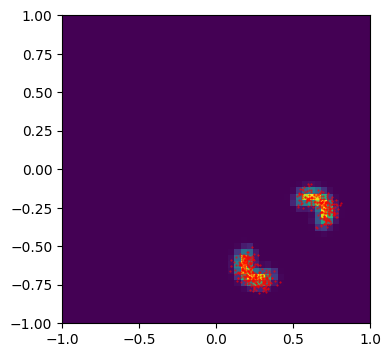

In [88]:
theta_np = theta_posterior_samples.numpy()

plt.figure(figsize=(4,4))
plt.imshow(ls.numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np[:,0], theta_np[:,1], 'r.', ms=1, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])